## Everything, Everywhere, All at Once:
### A study in finding the hidden stories in chaotic datasets
**Scenario:**<br><br>
As data anlystis, we were tasked by some big movie executives to help them determine what kind of movie they should be working on next. Based on IMDb data we are looking to discover trends and relationships in the data that can help guide decisions on which project the movie studio should make next.

### Questions for which we seek answers:
1. How do movie genre trends change over time?<br>
2. Do certain genres receive more votes or get better ratings?<br>
3. How popular are movies broken down by vote count?<br>
4. What principals (actors, actresses, directors, writers) are involved with the most popular and highest rated movies?<br>
5. Do any correlations exist between movies aspects (e.g. Total Votes, Ratings, Runtime, etc.)

### Sections:
* [Exploratory Data Analysis](#eda)
* [Data Cleaning](#data-cleaning)
* [Questions and Answers](#questions)

#### Exploratory Data Analysis <a class="anchor" id="eda"></a>

First we need to import our libraries and dataframes we will be working with from IMDb.

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
basics_df = pd.read_csv('Data/title.basics.tsv', sep='\t')
ratings_df = pd.read_csv('Data/title.ratings.tsv', sep='\t')

In [4]:
names_df = pd.read_csv('Data/name.basics.tsv', sep='\t')
principals_df = pd.read_csv('Data/title.principals.tsv', sep='\t')

We begin by looking at each data set to determine the datatypes and information available.

In [5]:
ratings_df.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2064
1,tt0000002,5.6,279
2,tt0000003,6.5,2038
3,tt0000004,5.4,180
4,tt0000005,6.2,2799


In [6]:
principals_df.head()

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0005690,producer,producer,\N
3,tt0000001,4,nm0374658,cinematographer,director of photography,\N
4,tt0000002,1,nm0721526,director,\N,\N


In [7]:
names_df.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","tt0072308,tt0050419,tt0053137,tt0027125"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack,archive_footage","tt0037382,tt0075213,tt0117057,tt0038355"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,music_department,producer","tt0057345,tt0049189,tt0056404,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,writer,music_department","tt0072562,tt0077975,tt0080455,tt0078723"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0083922,tt0050976,tt0069467"


The basics and ratings databases include a shared variable, so we can combine them

In [8]:
basics_ratings_df = basics_df.merge(ratings_df, how='inner', on='tconst')

### Data Cleaning <a class="anchor" id="data-cleaning"></a>
Cleaning the data for easier analysis and looking for the story

First, our clients are only looking for data on movies, so we can remove all other rows.

In [9]:
basics_ratings_df.titleType.unique()

array(['short', 'movie', 'tvShort', 'tvMovie', 'tvEpisode', 'tvSeries',
       'tvMiniSeries', 'tvSpecial', 'video', 'videoGame'], dtype=object)

In [10]:
movies_df = basics_ratings_df[basics_ratings_df.titleType == 'movie']

Then, we can determine variable types and correct as needed

In [11]:
movies_df.describe()

,averageRating,numVotes
count,314509.000000,3.145090e+05
mean,6.167837,3.621551e+03
std,1.360726,3.623180e+04
min,1.000000,5.000000e+00
25%,5.300000,1.900000e+01
50%,6.300000,6.100000e+01
75%,7.100000,3.130000e+02
max,10.000000,2.920364e+06


In [12]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 314509 entries, 8 to 1463604
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          314509 non-null  object 
 1   titleType       314509 non-null  object 
 2   primaryTitle    314509 non-null  object 
 3   originalTitle   314509 non-null  object 
 4   isAdult         314509 non-null  object 
 5   startYear       314509 non-null  object 
 6   endYear         314509 non-null  object 
 7   runtimeMinutes  314509 non-null  object 
 8   genres          314509 non-null  object 
 9   averageRating   314509 non-null  float64
 10  numVotes        314509 non-null  int64  
dtypes: float64(1), int64(1), object(9)
memory usage: 28.8+ MB


Creating a new column based off of decade to easily group data

In [13]:
def year_to_decade(x: str) -> str:
    x = x[0:3] + '0'
    return x

Converting strings to integers

In [14]:
def obj_to_int(x: str) -> int:
    x = int(x)
    return x

Removing null values and running the above functions

In [15]:
movies_df = movies_df[~(movies_df.runtimeMinutes == '\\N')]
movies_df = movies_df[~(movies_df.startYear  == '\\N')]
movies_df = movies_df[~(movies_df.genres  == '\\N')]
movies_df = movies_df[~(movies_df.averageRating  == '\\N')]
movies_df = movies_df[~(movies_df.numVotes  == '\\N')]
movies_df.runtimeMinutes = movies_df.runtimeMinutes.apply(obj_to_int)
movies_df['startYearInt'] = movies_df.startYear.apply(obj_to_int)
movies_df['decade'] = movies_df.startYear.apply(year_to_decade)

Removing outliers, any movies over 5 hours, and any movies with less than 100 rating votes

In [16]:
movies_df = movies_df[~(movies_df.runtimeMinutes > 300)]
movies_df = movies_df[movies_df.numVotes > 99]

Splitting the string of genres into a proper list

In [17]:
def genre_list(x:str) -> list:
    genre = x.split(',')
    return genre

Creating a new dataframe with just tconst and genres, to unwind and merge back into movies

In [18]:
genres_df = movies_df[['genres', 'tconst']]
genres_df.genres = genres_df.genres.apply(genre_list)

In [19]:
genres_df = genres_df.genres.apply(pd.Series) \
    .merge(genres_df, right_index = True, left_index = True) \
    .drop(['genres'], axis = 1) \
    .melt(id_vars = ['tconst'], value_name = 'genre') \
    .drop("variable", axis = 1) \
    .dropna()

Cleaning the genres, removing any that don't make sense for movies, that have too few entries, and combining related for easier to understand visualizations

In [20]:
genres_df = genres_df[~(genres_df.genre.isin(['Talk-Show', 'Reality-TV', 'News', 'Game-Show', 'Adult']))]

In [21]:
genres_df.genre = genres_df.genre.replace(['Thriller', 'Adventure'], 'Action')
genres_df.genre = genres_df.genre.replace(['History', 'Biography'], 'Documentary')
genres_df.genre = genres_df.genre.replace(['Sci-Fi', 'Fantasy'], 'Sci-Fi Fantasy')
genres_df.genre = genres_df.genre.replace(['Music'], 'Musical')
genres_df.genre = genres_df.genre.replace(['Film-Noir'], 'Mystery')
genres_df = genres_df.drop_duplicates()

Merging unwound genres back into movies

In [22]:
movies_genres_df = genres_df.merge(movies_df, how='left', on='tconst')

Removing columns that we don't need

In [23]:
movies_genres_df = movies_genres_df.drop(['endYear', 'originalTitle', 'genres', 'titleType', 'isAdult', 'genres', 'startYear'], axis=1)

The "ordering" and "characters" columns don't provide value so we drop them.

In [24]:
principals_df = principals_df.drop(columns=(['ordering', 'characters']), axis=1)

Removing deceased actors or actresses as we can't make decisions based on people who can no longer make movies.

In [25]:
names_df = names_df[(names_df.deathYear == '\\N')]

Dropping the "deathYear" column because it no longer has any valid values.

In [26]:
names_df = names_df.drop(columns=['deathYear'], axis=1)

Ensuring any null values are dropped so we are only working with known values.

In [27]:
names_df = names_df.dropna(subset=['primaryName'])

Creates one column for a main profession to make data easier to analyze.

In [28]:
def main_profession(professions):
    professions_list = professions.split(sep=',')
    return professions_list[0]

names_df['mainProfession'] = names_df['primaryProfession'].apply(main_profession)

Determining which categories exist and which are important for analysis

In [29]:
principals_df['category'].unique()

array(['self', 'director', 'producer', 'cinematographer', 'composer',
       'editor', 'actor', 'actress', 'writer', 'production_designer',
       'archive_footage', 'casting_director', 'archive_sound'],
      dtype=object)

Removing less important categories to focus on those with the most impact to help drive analysis and decision making.

In [30]:
principals_simplified_df = principals_df[(principals_df['category'].isin(['director', 'actor', 'actress', 'writer']))]

Job category doesn't provide much value so that will be dropped as well

In [31]:
principals_cleaned_df = principals_simplified_df.drop(columns=(['job']), axis=1)

Cleaning up the unwound movies dataframe so we have that without the genres creating duplicates

In [32]:
movies_cleaned_df = movies_df.drop(columns=['endYear', 'originalTitle', 'titleType', 'isAdult', 'startYear'], axis=1)

#### Questions and Answers <a class="anchor" id="questions"></a>

##### 1. How do movie genre trends change over time?
Using the unwound genres, we can chart the count of each over the timeline of the whole data set.

[Text(0.5, 1.0, 'Movie Genres over the Years'),
 Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Amount of Movies')]

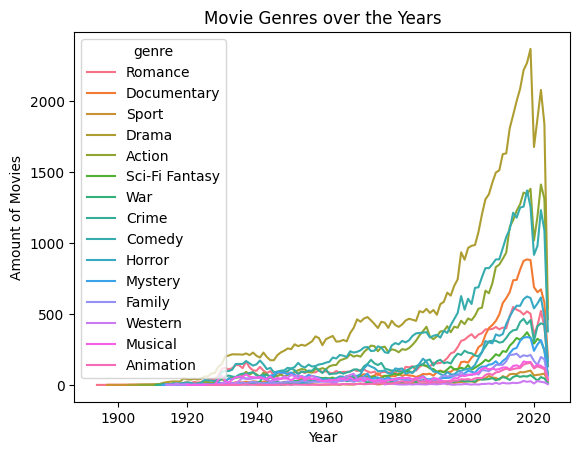

In [33]:
sns.lineplot(
    data=movies_genres_df.groupby(['startYearInt', 'genre']).size().reset_index(name='count'), x='startYearInt', y='count', hue='genre'
).set(title='Movie Genres over the Years', xlabel='Year', ylabel='Amount of Movies')

[Text(0.5, 1.0, 'Movie Genres over the Years'),
 Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Genre')]

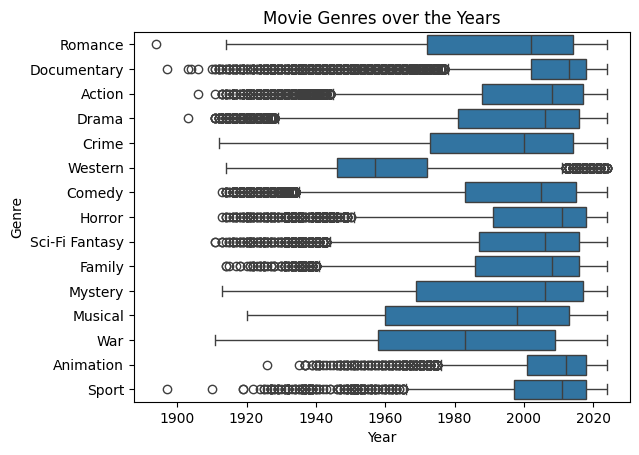

In [34]:
sns.boxplot(data=movies_genres_df, x='startYearInt', y='genre').set(title='Movie Genres over the Years', xlabel='Year', ylabel='Genre')

##### Answer:
Movie genres tend to stay pretty consistent over time, there's some fluctuation, but over the century they have porportionally stayed fairly consistent with a few interesting insights. 
1. Throughout the years Dramas have consistently reigned supreme
2. Documentaries have gotten far more popular in the 21st Century
3. Westerns while still being made were at their peak in the 1940s - 1960s
4. Animation has the most recent first value due to technologies allowing their creation

##### 2. Do certain genres receive more votes or get better ratings?

[Text(0.5, 1.0, 'Average Rating by Genre'),
 Text(0.5, 0, 'Genre'),
 Text(0, 0.5, 'Average Rating')]

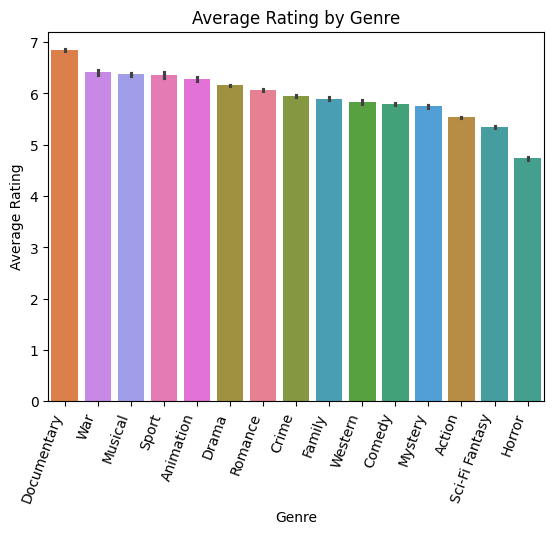

In [35]:
ax = sns.barplot(data=movies_genres_df, x='genre', y='averageRating', hue='genre', estimator='mean', order=['Documentary', 'War', 'Musical', 'Sport', 'Animation', 'Drama', 'Romance', 'Crime', 'Family', 'Western', 'Comedy', 'Mystery', 'Action', 'Sci-Fi Fantasy', 'Horror'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='right')
ax.set(title='Average Rating by Genre', xlabel='Genre', ylabel='Average Rating')

[Text(0.5, 1.0, 'Vote Engagement by Genre'),
 Text(0.5, 0, 'Genre'),
 Text(0, 0.5, 'Average Amount of Votes')]

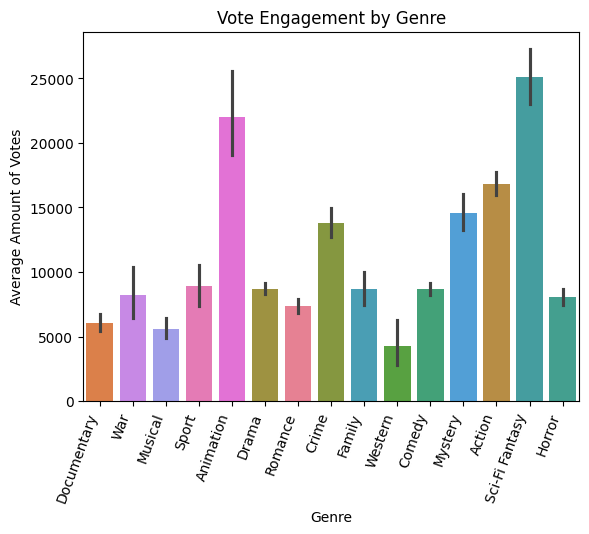

In [36]:
ax = sns.barplot(data=movies_genres_df, x='genre', y='numVotes', hue='genre', estimator='mean', order=['Documentary', 'War', 'Musical', 'Sport', 'Animation', 'Drama', 'Romance', 'Crime', 'Family', 'Western', 'Comedy', 'Mystery', 'Action', 'Sci-Fi Fantasy', 'Horror'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='right')
ax.set(title='Vote Engagement by Genre', xlabel='Genre', ylabel='Average Amount of Votes')

[Text(0.5, 1.0, 'Vote Engagement by Genre'),
 Text(0.5, 0, 'Genre'),
 Text(0, 0.5, 'Average Amount of Votes')]

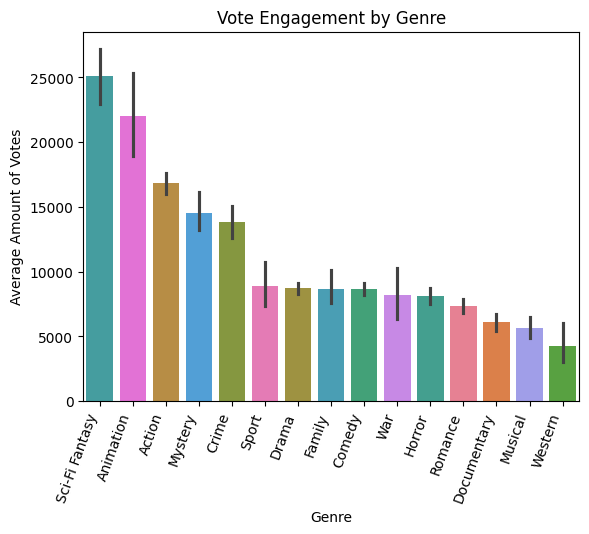

In [37]:
ax = sns.barplot(data=movies_genres_df, x='genre', y='numVotes', hue='genre', estimator='mean', order=['Sci-Fi Fantasy', 'Animation', 'Action', 'Mystery', 'Crime', 'Sport', 'Drama', 'Family', 'Comedy', 'War', 'Horror', 'Romance', 'Documentary', 'Musical', 'Western'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='right')
ax.set(title='Vote Engagement by Genre', xlabel='Genre', ylabel='Average Amount of Votes')

##### Answer:
We have some interesting insights on the connection between genres and ratings
1. Documentaries have the highest average rating, vs the third lowest amount of ratings, this shows that viewers may be more selective about seeing documentaries, only viewing ones that they already know they have an interest in the topic they are exploring.
2. Sci-Fi Fantasy has the highest average vote count, but the second lowest average rating, this shows that viewers are more drawn to seeing Sci-Fi Fantasy movies but not as likely to rate them highly

##### 3. How popular are movies broken down by vote count?

##### Answer:
Isolating out the top 100 most rated movies, and sorting that new dataframe, we can see that people tend to engage very highly with action/adventure/fantasy/sci-fi franchises, and that doesn't necessarily translate to high ratings as shown when we sort by average vote

##### 4. What principals (actors, actresses, directors, writers) are involved with the most popular and highest rated movies?

##### Answer:

Power BI can help cross-reference and identify movies success (popularity and ratings) with their related prinicpals (actor, actress, director, writer)<br><br>
One trend discovered is that popularity does not correspond with rating for all principals. For example, the director of the most popular movie (based on total votes) is Christopher Nolan, while Francis Ford Coppola has the highest rated movies while being ranked 8th in overall popularity. This also extends to writers as often writers also direct, which is the case for both Christopher Nolan and Francis Ford Coppola<br><br>
Actress and actor are show similar lack of correlations between popularity with Scarlett Johansson being the most popular actress while Diane Keaton has the highest rating and Leonard DiCaprio being most popular actor while Bob Gunton has the highest rating.

##### 5. Do any correlations exist between movies aspects (e.g. Total Votes, Ratings, Runtime, etc.)

In [38]:
movies_genres_df[['numVotes', 'averageRating', 'runtimeMinutes', 'startYearInt']].corr()

,numVotes,averageRating,runtimeMinutes,startYearInt
numVotes,1.000000,0.157131,0.130340,0.047362
averageRating,0.157131,1.000000,0.217649,-0.155415
runtimeMinutes,0.130340,0.217649,1.000000,0.186383
startYearInt,0.047362,-0.155415,0.186383,1.000000


In [39]:
movies_noshort_df = movies_df[movies_df.runtimeMinutes > 90]

In [40]:
movies_noshort_df[['numVotes', 'averageRating', 'runtimeMinutes', 'startYearInt']].corr()

,numVotes,averageRating,runtimeMinutes,startYearInt
numVotes,1.000000,0.155389,0.093279,0.028705
averageRating,0.155389,1.000000,0.220279,-0.157528
runtimeMinutes,0.093279,0.220279,1.000000,0.034167
startYearInt,0.028705,-0.157528,0.034167,1.000000


##### Answer:
The highest correlation is for Run Time and Average Rating, but that is still very low at a .22, it rises ever so slightly when anything less than 1.5 hours is removed but still very low correlation